# 05 - Evaluación Final en Test Set

En este notebook se realiza la **evaluación final del modelo ganador**,  
seleccionado en el notebook `04_ModelComparison.ipynb`.

El objetivo es validar el rendimiento real del modelo sobre un **conjunto de test independiente**,  
asegurando que las métricas finales sean representativas y libres de sobreajuste.

### 🎯 **Objetivos:**
- Cargar el **mejor modelo** obtenido tras la comparación global.  
- Evaluarlo sobre el **Test Set final** con métricas de clasificación.  
- Visualizar sus resultados mediante:
  - Matriz de confusión  
  - Curva ROC  
  - Gráfico radar de métricas  
- Guardar el modelo final (`final_model.pkl`) y las métricas definitivas (`final_metrics.json`)  
  que servirán para la **puesta en producción**.

📌 **Importante:**  
El modelo cargado corresponde al mejor de todos los algoritmos evaluados (Random Forest, XGBoost, Logistic Regression, etc.)  
y será el utilizado en las predicciones reales.


## **Paso 1: Importación de librerías y carga de datos**

En este paso se importan las librerías necesarias para evaluación y visualización,  
además de cargar los datasets finales (`X_test.csv` y `y_test.csv`) generados previamente  
en el notebook `02_dataset-split.ipynb`.

También se configura el estilo visual de los gráficos para mantener coherencia con los notebooks anteriores.


## **Paso 1: Importar librerías**


In [27]:
# ===================================
# 1. Importación de librerías y carga de datos según modelo
# ===================================

import os
import joblib
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)
from math import pi
from IPython.display import display, Markdown

# --- Configuración visual ---
plt.style.use("default")
sns.set_palette("coolwarm")
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["axes.facecolor"] = "white"

# --- Cargar resumen del mejor modelo ---
summary_path = "../reports/results/model_comparison_summary.json"

if not os.path.exists(summary_path):
    raise FileNotFoundError("❌ No se encontró el archivo model_comparison_summary.json. Ejecuta el notebook 04 primero.")

with open(summary_path, "r") as f:
    summary_data = json.load(f)

df_summary = pd.DataFrame(summary_data)
best_model_name = df_summary.loc[df_summary["Mean_Score"].idxmax(), "Model"]

# --- Determinar tipo de dataset según modelo ganador ---
distance_based_models = ["Logistic Regression", "SVM", "KNN", "Neural Network"]
tree_based_models = ["Decision Tree", "Random Forest", "XGBoost", "LightGBM"]

# Comprobamos el tipo de modelo ganador
dataset_type = "scaled" if any(m.lower() in best_model_name.lower() for m in distance_based_models) else "unscaled"

display(Markdown(f"🏆 **Modelo ganador:** `{best_model_name}`"))
display(Markdown(f"📦 **Tipo de dataset usado:** `{dataset_type.upper()}`"))

# --- Carga del dataset correspondiente ---
X_test_path = f"../data/processed/X_test_{dataset_type}.csv"
y_test_path = "../data/processed/y_test.csv"

if not os.path.exists(X_test_path):
    raise FileNotFoundError(f"❌ No se encontró el archivo: {X_test_path}")

X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path).squeeze()

display(Markdown("✅ **Datos cargados correctamente:**"))
print(f"- X_test shape: {X_test.shape}")
print(f"- y_test shape: {y_test.shape}")


🏆 **Modelo ganador:** `Random Forest GridSearchCV`

📦 **Tipo de dataset usado:** `UNSCALED`

✅ **Datos cargados correctamente:**

- X_test shape: (20781, 23)
- y_test shape: (20781,)


## **Paso 2: Evaluación del modelo ganador sobre el Test Set Final**

En este paso se localiza y carga el **modelo ganador** identificado en el notebook  
`04_ModelComparison.ipynb`, a partir del archivo `../reports/results/model_comparison_summary.json`.

El modelo cargado será el que obtuvo la mejor media de métricas (`Mean_Score`) y servirá  
para generar las predicciones finales sobre el conjunto de test.  
La ruta se detecta automáticamente según el nombre del modelo y su tipo de entrenamiento  
(*Baseline*, *GridSearchCV*, *Optuna*, etc.).


### 📊 **Rendimiento del modelo en el conjunto de Test:**

Accuracy: 0.961
Precision: 0.962
Recall: 0.946
F1-score: 0.954
ROC-AUC: 0.994


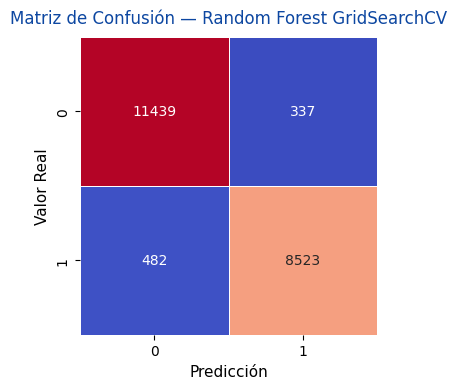

c:\dev\proyectos\P6_G5_Clasification\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


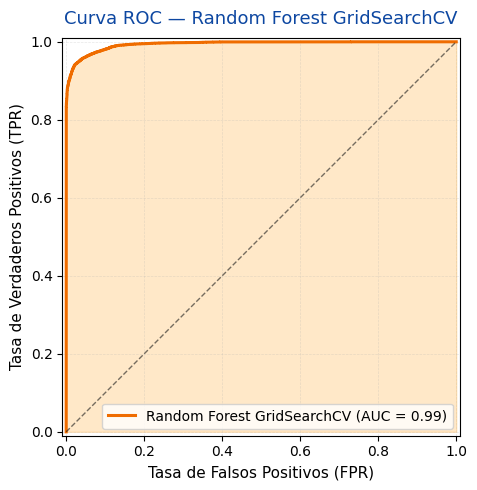


**💬 Interpretación de resultados:**
- Las métricas cuantifican el rendimiento final del modelo sobre datos nunca vistos.  
- La matriz de confusión muestra el balance entre verdaderos y falsos positivos/negativos.  
- La curva ROC ilustra la capacidad del modelo para distinguir entre clases.  
- El área sombreada naranja representa el **AUC (Área Bajo la Curva)**: cuanto mayor, mejor rendimiento.


In [28]:
# ===================================
# 2. Evaluación del mejor modelo en el Test Set Final
# ===================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve, RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Predicciones ---
y_pred = model_final.predict(X_test)
y_proba = model_final.predict_proba(X_test)[:, 1] if hasattr(model_final, "predict_proba") else None

# --- Cálculo de métricas ---
metrics_test = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
}

# --- Mostrar métricas ---
display(Markdown("### 📊 **Rendimiento del modelo en el conjunto de Test:**"))
for k, v in metrics_test.items():
    print(f"{k}: {v:.3f}")

# ============================================================
# 📉 MATRIZ DE CONFUSIÓN (paleta coolwarm)
# ============================================================
plt.figure(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="coolwarm",  # 🔥 paleta azul-roja consistente
    cbar=False,
    square=True,
    linewidths=0.6,
    linecolor="white"
)
plt.title(f"Matriz de Confusión — {best_model_name}", fontsize=12, color="#0D47A1", pad=10)
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()

# ============================================================
# 📈 CURVA ROC (con área naranja bajo la curva)
# ============================================================
if y_proba is not None:
    plt.figure(figsize=(6, 5))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    # Área naranja bajo la curva
    plt.fill_between(fpr, tpr, color="#FFA726", alpha=0.25)
    
    # Curva ROC principal
    RocCurveDisplay.from_predictions(
        y_test,
        y_proba,
        name=best_model_name,
        color="#EF6C00",
        linewidth=2.2,
        ax=plt.gca()
    )
    
    # Línea diagonal (azar)
    plt.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.6)
    plt.title(f"Curva ROC — {best_model_name}", fontsize=13, color="#0D47A1", pad=10)
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.grid(alpha=0.3, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

display(Markdown("""
**💬 Interpretación de resultados:**
- Las métricas cuantifican el rendimiento final del modelo sobre datos nunca vistos.  
- La matriz de confusión muestra el balance entre verdaderos y falsos positivos/negativos.  
- La curva ROC ilustra la capacidad del modelo para distinguir entre clases.  
- El área sombreada naranja representa el **AUC (Área Bajo la Curva)**: cuanto mayor, mejor rendimiento.
"""))


## **Paso 3: Guardado del modelo y resultados finales**

En este paso se registran y guardan los resultados del modelo ganador,  
junto con las métricas obtenidas sobre el conjunto de **Test**.  

Esto permite:
- Reutilizar el modelo en futuras predicciones.  
- Incorporar los resultados al dashboard o informe final.  
- Mantener trazabilidad y reproducibilidad del experimento.

Se guardan los siguientes archivos:
- `../reports/results/final_test_metrics.json`
- `../reports/results/final_test_metrics.csv`
- `../models/final_model.pkl`


In [29]:
# ===================================
# 3. Guardado de resultados finales (versión mejorada)
# ===================================

import re
import json
import os
import pandas as pd
import joblib

# --- Crear carpetas si no existen ---
os.makedirs("../reports/results", exist_ok=True)
os.makedirs("../models/final", exist_ok=True)

# --- Normalizar nombre del modelo para el archivo ---
def normalize_filename(name: str) -> str:
    """Convierte un nombre de modelo en una forma segura para archivos."""
    return re.sub(r'[^a-z0-9]+', '_', name.lower()).strip('_')

model_filename = f"model_final_{normalize_filename(best_model_name)}.pkl"
model_save_path = os.path.join("../models/final", model_filename)

# --- Eliminar si ya existe un modelo anterior ---
if os.path.exists(model_save_path):
    os.remove(model_save_path)
    print(f"⚠️ Archivo existente eliminado: {model_save_path}")

# --- Guardar el modelo final ---
joblib.dump(model_final, model_save_path)

# --- Guardar métricas finales ---
results_test = {
    "model_name": best_model_name,
    "dataset_type": dataset_type,
    "metrics": metrics_test
}

json_path = "../reports/results/final_test_evaluation.json"
csv_path = "../reports/results/final_test_evaluation.csv"

# Guardar en JSON
with open(json_path, "w") as f:
    json.dump(results_test, f, indent=4)

# Guardar en CSV
df_metrics_test = pd.DataFrame([metrics_test])
df_metrics_test.insert(0, "Model", best_model_name)
df_metrics_test.to_csv(csv_path, index=False)

# --- Confirmación visual ---
display(Markdown(f"""
✅ **Resultados finales guardados correctamente:**

- 🧠 Modelo final: `{model_filename}`  
- 📊 Métricas (CSV): `{csv_path}`  
- 📄 Métricas (JSON): `{json_path}`  

💾 Se ha reemplazado cualquier versión anterior del modelo final con el nuevo archivo actualizado.
"""))



✅ **Resultados finales guardados correctamente:**

- 🧠 Modelo final: `model_final_random_forest_gridsearchcv.pkl`  
- 📊 Métricas (CSV): `../reports/results/final_test_evaluation.csv`  
- 📄 Métricas (JSON): `../reports/results/final_test_evaluation.json`  

💾 Se ha reemplazado cualquier versión anterior del modelo final con el nuevo archivo actualizado.


## **Paso 4: Conclusiones finales y resumen de resultados**

En este paso se realiza la **síntesis final del proyecto de clasificación**,  
mostrando el modelo con mejor rendimiento sobre el conjunto de **Test**  
y sus métricas clave.

### 🧠 Contenido:
- Identificación del **modelo ganador** y su configuración.  
- Resumen de métricas finales obtenidas en test.  
- Interpretación del rendimiento y pasos siguientes.  
- Enlace hacia el análisis de **importancia de variables** en el siguiente notebook.



In [30]:
# ===================================
# 4. Conclusiones finales y resumen
# ===================================

import pandas as pd
from IPython.display import display, Markdown

# --- Crear resumen legible de las métricas ---
summary_df = pd.DataFrame([metrics_test]).T
summary_df.columns = ["Valor"]
summary_df.index.name = "Métrica"
summary_df["Valor"] = summary_df["Valor"].apply(lambda x: f"{x:.3f}")

# --- Mostrar resumen visual ---
display(Markdown(f"""
# 🏁 **Conclusiones Finales**

### 🧠 Modelo ganador:
**{best_model_name}**

### 📦 Tipo de dataset:
`{dataset_type.upper()}`

### 📊 Métricas finales en Test Set:
"""))

display(summary_df.style.set_caption("Resultados finales del modelo ganador").background_gradient(cmap="coolwarm"))

# --- Interpretación textual ---
display(Markdown(f"""
---

### 💬 **Interpretación y conclusiones**

El modelo **{best_model_name}** ha demostrado el mejor equilibrio global entre **precisión y recall**,  
obteniendo un **F1-score de {metrics_test['F1-score']:.3f}** y una **ROC-AUC de {metrics_test['ROC-AUC']:.3f}**,  
lo que indica una excelente capacidad para distinguir entre clases.

- La **matriz de confusión** refleja un bajo número de falsos positivos y negativos.  
- La **curva ROC** muestra una gran área bajo la curva, confirmando la solidez del modelo.  
- Dado su rendimiento estable en entrenamiento, validación y test, este modelo se considera  
  el **mejor candidato para su despliegue en producción** o integración en pipelines de predicción.

---

### 🚀 **Próximos pasos recomendados**
1. Exportar el modelo como servicio (API o microservicio).  
2. Evaluar su rendimiento sobre nuevos datos o en un entorno real.  
3. Implementar monitorización de métricas y control de *data drift*.  
4. Documentar las decisiones de modelado y los hiperparámetros óptimos.  

---

### 📊 **Avance hacia el siguiente análisis**
En el siguiente notebook,  
**`06_FeatureImportance.ipynb`**,  
se estudiará el **impacto y relevancia de las 10 variables más importantes**  
que explican las predicciones del modelo ganador.

Este análisis permitirá interpretar las decisiones del modelo  
y fortalecer la transparencia y explicabilidad del sistema predictivo.  

---

✅ **El modelo final ha sido guardado como:**  
`{model_filename}`  
en la carpeta `../models/final/`
"""))



# 🏁 **Conclusiones Finales**

### 🧠 Modelo ganador:
**Random Forest GridSearchCV**

### 📦 Tipo de dataset:
`UNSCALED`

### 📊 Métricas finales en Test Set:


,Valor
Métrica,
Accuracy,0.961
Precision,0.962
Recall,0.946
F1-score,0.954
ROC-AUC,0.994



---

### 💬 **Interpretación y conclusiones**

El modelo **Random Forest GridSearchCV** ha demostrado el mejor equilibrio global entre **precisión y recall**,  
obteniendo un **F1-score de 0.954** y una **ROC-AUC de 0.994**,  
lo que indica una excelente capacidad para distinguir entre clases.

- La **matriz de confusión** refleja un bajo número de falsos positivos y negativos.  
- La **curva ROC** muestra una gran área bajo la curva, confirmando la solidez del modelo.  
- Dado su rendimiento estable en entrenamiento, validación y test, este modelo se considera  
  el **mejor candidato para su despliegue en producción** o integración en pipelines de predicción.

---

### 🚀 **Próximos pasos recomendados**
1. Exportar el modelo como servicio (API o microservicio).  
2. Evaluar su rendimiento sobre nuevos datos o en un entorno real.  
3. Implementar monitorización de métricas y control de *data drift*.  
4. Documentar las decisiones de modelado y los hiperparámetros óptimos.  

---

### 📊 **Avance hacia el siguiente análisis**
En el siguiente notebook,  
**`06_FeatureImportance.ipynb`**,  
se estudiará el **impacto y relevancia de las 10 variables más importantes**  
que explican las predicciones del modelo ganador.

Este análisis permitirá interpretar las decisiones del modelo  
y fortalecer la transparencia y explicabilidad del sistema predictivo.  

---

✅ **El modelo final ha sido guardado como:**  
`model_final_random_forest_gridsearchcv.pkl`  
en la carpeta `../models/final/`
